> Ref: Amplitude의 [Product Analytics Playbook: Mastering Retention](https://www.productanalyticsplaybook.com/#top)

위의 내용 中 1. **리텐션 커브** 2. **리텐션 라이프사이클 프레임워크** 에 대한 분석 및 시각화 작업과 이를 파이프라인화 할 수 있는 메소드를 만들어본다.

# 1. 데이터 가공 단계

- 소스가 되는 데이터의 형태는 웹/앱에서 발생하는 이벤트 로그를 가정
- 이벤트 로그를 기반으로 리텐션 분석이 가능한 형태의 테이블 만들기
- 데이터 처리는 pyspark를 통해 진행

In [1]:
import os
# os.environ["PYSPARK_PYTHON"] = "/opt/homebrew/bin/python3"

In [2]:
from pyspark.sql import SparkSession, Row, DataFrame
from pyspark import SparkContext

In [6]:
MAX_MEMORY = "32g"
SPARK = (
    SparkSession.builder.appName("Plots Tutorial Shell")
    .config("spark.driver.host", "localhost")
    .config("spark.driver.memory", MAX_MEMORY)
    .config("spark.sql.session.timeZone", "Asia/Seoul")
    .config("spark.driver.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .config("spark.executor.extraJavaOptions", "-Duser.timezone=Asia/Seoul")
    .getOrCreate()
)

21/07/11 16:35:23 WARN SparkContext: Another SparkContext is being constructed (or threw an exception in its constructor). This may indicate an error, since only one SparkContext should be running in this JVM (see SPARK-2243). The other SparkContext was created at:
org.apache.spark.api.java.JavaSparkContext.<init>(JavaSparkContext.scala:58)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance0(Native Method)
java.base/jdk.internal.reflect.NativeConstructorAccessorImpl.newInstance(NativeConstructorAccessorImpl.java:62)
java.base/jdk.internal.reflect.DelegatingConstructorAccessorImpl.newInstance(DelegatingConstructorAccessorImpl.java:45)
java.base/java.lang.reflect.Constructor.newInstanceWithCaller(Constructor.java:500)
java.base/java.lang.reflect.Constructor.newInstance(Constructor.java:481)
py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:247)
py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
py4j.Gateway.invoke(Gateway.java:238)
py4j.command

In [7]:
import datetime

In [8]:
# event log samples

event_logs = SPARK.createDataFrame(
    [
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="3215", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1400", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="1000", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="800", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="600", event_name="lectureplay"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="580", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="582", event_name="lectureplay"),
        Row(timestamp=datetime.datetime(2021, 7, 1, 1, 1, 1), user_id="550", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="3215", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1400", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 2, 1, 1, 1), user_id="1000", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="3215", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="1400", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="1000", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="800", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 3, 1, 1, 1), user_id="600", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 4, 1, 1, 1), user_id="580", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 5, 1, 1, 1), user_id="582", event_name="chat"),
        Row(timestamp=datetime.datetime(2021, 7, 6, 1, 1, 1), user_id="550", event_name="chat"),
    ]
)

## TASK1: 특정 이벤트 발생을 기준으로 유저 리텐션 측정

In [9]:
from typing import Literal, Union, Optional, List
from pyspark.sql import Window
import pyspark.sql.functions as F
import pyspark.sql.types as T
from math import floor

Retention 측정 방법 세 가지
1. N-Day
2. Bracket
3. Unbounded

In [10]:
RetentionType = Union[Literal["N-Day"], Literal["Bracket"], Literal["Unbounded"]]

In [11]:
def get_date_brackets(
    start_date: datetime.date, 
    end_date: datetime.date, 
    bracket_sizes: List[int]
) -> List[List[datetime.date]]:
    idx = 0
    lower = start_date
    upper = min([start_date + datetime.timedelta(days=bracket_sizes[idx] - 1), end_date])
    brackets = [[lower, upper]]
    while idx + 1 < len(bracket_sizes) and upper < end_date:
        idx += 1
        lower = upper + datetime.timedelta(days=1)
        upper = min([upper + datetime.timedelta(days=bracket_sizes[idx]), end_date])
        brackets.append([lower, upper])
    
    return brackets


def get_retention_df(
    event_logs: DataFrame,
    event_name: str,
    start_date: datetime.date,
    end_date: datetime.date,
    retention_type: RetentionType, 
    bracket_size: Optional[int] = None,
    custom_bracket_sizes: Optional[List[int]] = None, 
) -> DataFrame:  
    window_size = (end_date - start_date).days + 1
    
    df_filtered = (
        event_logs
        .filter(F.col("event_name") == event_name)
        
        .withColumn("date", F.col("timestamp").cast(T.DateType()))
        .filter((F.col("date") >= start_date) & (F.col("date") <= end_date))
    )
    
    if retention_type == "N-Day":
        df_filtered = (
            df_filtered
            .withColumn(
                "cohort_members", 
                F.first(F.collect_set("user_id").over(Window.partitionBy("date"))).over(Window.partitionBy().orderBy("date"))
            )
            .filter(F.array_contains(F.col("cohort_members"), F.col("user_id")))
        )
        
        df_grouped_by_date = (
            df_filtered
            .groupBy("date", "event_name")
            .agg(
                F.collect_set("user_id").alias("user_ids")
            )
        )
        
        df_grouped = (
            df_grouped_by_date
            .withColumn("range_index", F.row_number().over(Window.partitionBy().orderBy("date")) - 1)
        )
        
        template_df = SPARK.createDataFrame(
            [
                Row(
                    range_index=i, 
                    date=start_date + datetime.timedelta(days=i), 
                    event_name=event_name,
                    retention_type=retention_type
                ) for i in range(window_size)
            ]
        )
    elif retention_type == "Bracket":
        assert bracket_size is not None or custom_bracket_sizes is not None
        
        if custom_bracket_sizes:
            cohort_members = (
                df_filtered
                .filter(F.col("date") <= start_date + datetime.timedelta(days=custom_bracket_sizes[0] - 1))
                .select(F.collect_set("user_id").alias("user_ids"))
                .first()
                .user_ids
            )
            df_filtered = (
                df_filtered
                .filter(F.col("user_id").isin(cohort_members))
            )
            
            bracket_sizes = custom_bracket_sizes
            
        else:
            cohort_members = (
                df_filtered
                .filter(F.col("date") <= start_date + datetime.timedelta(days=bracket_size - 1))
                .select(F.collect_set("user_id").alias("user_ids"))
                .first()
                .user_ids
            )
            df_filtered = (
                df_filtered
                .filter(F.col("user_id").isin(cohort_members))
            )
            bracket_sizes = [bracket_size] * floor(window_size / bracket_size)
            bracket_sizes += [window_size - sum(bracket_sizes)]
            
        brackets = get_date_brackets(start_date=start_date, end_date=end_date, bracket_sizes=bracket_sizes)
        
        @F.udf(T.IntegerType())
        def bracket_mapper(date: datetime.date):
            for idx, (lower, upper) in enumerate(brackets):
                if date >= lower and date <= upper:
                    return idx

        df_grouped_by_bracket = (
            df_filtered
            .withColumn("bracket", bracket_mapper("date"))
            .groupBy("bracket", "event_name")
            .agg(
                F.collect_set("user_id").alias("user_ids"),
                F.array(F.min("date"), F.max("date")).alias("date"),
            )
        )

        df_grouped = (
            df_grouped_by_bracket
            .withColumnRenamed("bracket", "range_index")
        )
        
        template_df = SPARK.createDataFrame(
            [
                Row(
                    range_index=i, 
                    date=brackets[i], 
                    event_name=event_name,
                    retention_type=retention_type
                ) for i in range(len(brackets))
            ]
        )
            
    elif retention_type == "Unbounded":
        df_filtered = (
            df_filtered
            .withColumn(
                "cohort_members", 
                F.first(F.collect_set("user_id").over(Window.partitionBy("date"))).over(Window.partitionBy().orderBy("date"))
            )
            .filter(F.array_contains(F.col("cohort_members"), F.col("user_id")))
        )
        
        df_grouped_by_date = (
            df_filtered
            .withColumn(
                "user_ids", 
                F.collect_set("user_id").over(Window.partitionBy().orderBy("date").rowsBetween(Window.currentRow, Window.unboundedFollowing))
            )
            .dropDuplicates(["date", "event_name"])
        )
        
        df_grouped = (
            df_grouped_by_date
            .withColumn("range_index", F.row_number().over(Window.partitionBy().orderBy("date")) - 1)
        )
        
        template_df = SPARK.createDataFrame(
            [
                Row(
                    range_index=i, 
                    date=start_date + datetime.timedelta(days=i), 
                    event_name=event_name,
                    retention_type=retention_type
                ) for i in range(window_size)
            ]
        )
    else:
        raise ValueError("Retention type undefined.")
    
    cohort_size = F.first("num_users").over(Window.partitionBy().orderBy("range_index"))
    retention_df = (
        template_df
        .join(
            df_grouped.withColumn("num_users", F.size("user_ids")).select("range_index", "num_users"),
            on=["range_index"],
            how="left"
        )
        .fillna(subset=["num_users"], value=0)
        .withColumn("retention_rate", F.col("num_users") / cohort_size)
    )
    
    return retention_df.select(
        "range_index",
        "date",
        "event_name",
        "retention_type",
        "num_users",
        "retention_rate"
    )

### N-day 방식 샘플

In [12]:
retention_df = get_retention_df(
    event_logs=event_logs, 
    event_name="chat",
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6), 
    retention_type="N-Day",
)

In [13]:
retention_df.show(20, False)

21/07/11 16:35:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 16:35:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 16:35:38 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+----------+----------+--------------+---------+-------------------+
|range_index|date      |event_name|retention_type|num_users|retention_rate     |
+-----------+----------+----------+--------------+---------+-------------------+
|0          |2021-07-01|chat      |N-Day         |6        |1.0                |
|1          |2021-07-02|chat      |N-Day         |3        |0.5                |
|2          |2021-07-03|chat      |N-Day         |3        |0.5                |
|3          |2021-07-04|chat      |N-Day         |2        |0.3333333333333333 |
|4          |2021-07-05|chat      |N-Day         |1        |0.16666666666666666|
|5          |2021-07-06|chat      |N-Day         |0        |0.0                |
+-----------+----------+----------+--------------+---------+-------------------+



### Bracket 방식 샘플

In [14]:
retention_df = get_retention_df(
    event_logs=event_logs, 
    event_name="chat",
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6), 
    retention_type="Bracket",
    bracket_size=2
)

In [15]:
retention_df.show(20, False)

21/07/11 16:35:51 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+------------------------+----------+--------------+---------+-------------------+
|range_index|date                    |event_name|retention_type|num_users|retention_rate     |
+-----------+------------------------+----------+--------------+---------+-------------------+
|0          |[2021-07-01, 2021-07-02]|chat      |Bracket       |6        |1.0                |
|1          |[2021-07-03, 2021-07-04]|chat      |Bracket       |5        |0.8333333333333334 |
|2          |[2021-07-05, 2021-07-06]|chat      |Bracket       |1        |0.16666666666666666|
+-----------+------------------------+----------+--------------+---------+-------------------+



### Unbounded 방식 샘플

In [16]:
retention_df = get_retention_df(
    event_logs=event_logs, 
    event_name="chat",
    start_date=datetime.date(2021, 7, 1), 
    end_date=datetime.date(2021, 7, 6), 
    retention_type="Unbounded",
)

In [17]:
retention_df.show(20, False)

21/07/11 16:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 16:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 16:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 16:35:56 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


+-----------+----------+----------+--------------+---------+-------------------+
|range_index|date      |event_name|retention_type|num_users|retention_rate     |
+-----------+----------+----------+--------------+---------+-------------------+
|0          |2021-07-01|chat      |Unbounded     |6        |1.0                |
|1          |2021-07-02|chat      |Unbounded     |6        |1.0                |
|2          |2021-07-03|chat      |Unbounded     |6        |1.0                |
|3          |2021-07-04|chat      |Unbounded     |3        |0.5                |
|4          |2021-07-05|chat      |Unbounded     |1        |0.16666666666666666|
|5          |2021-07-06|chat      |Unbounded     |0        |0.0                |
+-----------+----------+----------+--------------+---------+-------------------+



## TASK2: 리텐션 라이프사이클에 따른 유저 그룹 분류

1. New Users
2. Current Users(+Power Users)
3. Resurrected Users
4. Dormant Users

유저 그룹 분류를 위해서는 이벤트 유형에 따른 유저의 리텐션 주기를 미리 파악하고 있어야 함

*chat 이벤트의 주기는 하루(daily)로 가정*

In [47]:
from collections import defaultdict
from typing import Tuple


def get_intervals(today: datetime.date, retention_cycle: int) -> Tuple[List[datetime.date]]:
    current_interval = []
    for i in range(retention_cycle):
        current_interval.append(today - datetime.timedelta(days=i))
    current_interval.sort()
    
    previous_interval = []
    for j in range(retention_cycle, retention_cycle * 2):
        previous_interval.append(today - datetime.timedelta(days=j))
    previous_interval.sort()
    
    return previous_interval, current_interval


def classify_user_groups(
    event_logs: DataFrame,
    event_name: str,
    retention_cycle: int,
    today: datetime.date
) -> DataFrame:
    df_filtered = event_logs.filter(F.col("event_name") == event_name)
    daily_user_groups = {
        row.date: {"active_users": row.active_users, "new_users": row.new_users, "user_pool": row.user_pool}
        for row in (
            df_filtered
            .withColumn("date", F.col("timestamp").cast(T.DateType()))
            .withColumn(
                "new_user_flag", 
                F.when(
                    F.min("timestamp").over(Window.partitionBy("user_id")) == F.col("timestamp"), 
                    F.col("user_id")
                ).otherwise(F.lit(None))
            )
            .withColumn(
                "all_users_so_far",
                F.collect_set("user_id").over(Window.partitionBy().orderBy("timestamp").rowsBetween(Window.unboundedPreceding, Window.currentRow))
            )
            .orderBy("timestamp")
            .groupBy("event_name", "date")
            .agg(
                F.collect_set("user_id").alias("active_users"),
                F.collect_set("new_user_flag").alias("new_users"),
                F.last("all_users_so_far").alias("user_pool")
            )
            .collect()
        )
    }
    
    start_date = event_logs.select(F.min("timestamp").cast(T.DateType()).alias("start_date")).first().start_date
    date_range = [start_date + datetime.timedelta(days=i) for i in range((today - start_date).days + 1)]
    user_classifications = defaultdict(dict)
    for date in date_range:
        previous_interval, current_interval = get_intervals(today=date, retention_cycle=retention_cycle)
        
        # 1. New Users & Active Users
        new_users = set()
        active_users = set()
        for _date in set(current_interval) & set(date_range):
            new_users |= set(daily_user_groups[_date]["new_users"])
            active_users |= set(daily_user_groups[_date]["active_users"])

        user_classifications[date]["new_users"] = new_users
        
        # 2. Current Users
        was_active_users = set()
        for _date in set(previous_interval) & set(date_range):
            if _date not in date_range:
                continue
            was_active_users |= set(daily_user_groups[_date]["active_users"])
        
        user_classifications[date]["current_users"] = active_users & was_active_users
        
        # 3. Resurrected Users
        user_classifications[date]["resurrected_users"] = active_users - was_active_users - new_users
        
        # 4. Dormant Users
        user_pool_so_far = set(daily_user_groups[date]["user_pool"])
        
        user_classifications[date]["dormant_users"] = user_pool_so_far - active_users
        
    user_classification_df = SPARK.createDataFrame(
        [
            Row(
                event_name=event_name,
                date=date,
                new_users=len(user_groups["new_users"]),
                current_users=len(user_groups["current_users"]),
                resurrected_users=len(user_groups["resurrected_users"]),
                dormant_users=len(user_groups["dormant_users"])
            ) for date, user_groups in user_classifications.items()
        ]
    )
    
    return user_classification_df

### 유저 그룹 분류 샘플

In [49]:
user_group_df = classify_user_groups(
    event_logs=event_logs,
    event_name="chat",
    retention_cycle=1,
    today=datetime.date(2021, 7, 6)
)

21/07/11 21:09:58 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


In [50]:
user_group_df.show()

+----------+----------+---------+-------------+-----------------+-------------+
|event_name|      date|new_users|current_users|resurrected_users|dormant_users|
+----------+----------+---------+-------------+-----------------+-------------+
|      chat|2021-07-01|        6|            0|                0|            0|
|      chat|2021-07-02|        0|            3|                0|            3|
|      chat|2021-07-03|        1|            2|                1|            3|
|      chat|2021-07-04|        0|            0|                2|            5|
|      chat|2021-07-05|        1|            0|                0|            7|
|      chat|2021-07-06|        0|            0|                1|            7|
+----------+----------+---------+-------------+-----------------+-------------+



# 2. 시각화 단계

- seaborn 사용해서 기본 테마 잡고
- color 직접 지정해서 plot 커스텀할 수 있는 시각화 메소드 구현

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

%matplotlib inline

## TASK1: 리텐션 커브 &rarr; Line Plot

In [21]:
from typing import Tuple

In [22]:
def plot_retention_curve(
    retention_df: DataFrame,
    figsize: Tuple[str],
    facecolor: str,
    linecolor: str,
    linestyle: str,
    marker: str,
    markersize: int,
    fontfamily: str,
    fontcolor: str,
    fontsize: int
) -> plt.Figure:
    
    data = retention_df.orderBy("range_index").select("range_index", "date", "retention_rate", "num_users").collect()
    x_range = [row.range_index for row in data]
    xlabel_date = [row.date for row in data]
    y_retention_rate = [row.retention_rate for row in data]
    y_num_users = [row.num_users for row in data]
    
    sns.set_theme(
        context="notebook",
        style="darkgrid",
        font=fontfamily,
        rc={
            "figure.figsize": figsize,
            "axes.facecolor": facecolor,
        }
    )
    fig = plt.figure()
    ax = fig.subplots()
    
    ax.plot(
        x_range,
        y_retention_rate,
        color=linecolor,
        ls=linestyle,
        marker=marker,
        ms=markersize,
    )

    # Set plot title
    ax.set_title("Retention Curve", size=fontsize*1.5, color=fontcolor)

    # Set x tick & label
    ax.set_xlabel(None)
    ax.set_xticks(x_range)
    retention_type = retention_df.select("retention_type").first().retention_type
    if retention_type == "Bracket":
        x_labels = [
            f"{start_date.month}/{start_date.day}~{end_date.month}/{end_date.day}" 
            for start_date, end_date in xlabel_date
        ]
        ax.set_xticklabels(x_labels, fontsize=fontsize, color=fontcolor, rotation=20)
    else:
        x_labels = [f"{date.month}/{date.day}" for date in xlabel_date]
        ax.set_xticklabels(x_labels, fontsize=fontsize, color=fontcolor)

    # Set y tick & label
    ax.set_ylabel(None)
    ax.set_yticks(np.arange(0, 1.01, .1))
    ax.set_yticks(np.arange(0, 1.01, .05), minor=True)
    y_labels = ["{:.0%}".format(r) for r in np.arange(0, 1.01, .1)]
    ax.set_yticklabels(y_labels, fontsize=fontsize, color=fontcolor)

    # Set grid
    ax.grid(True, which="major", axis="y", ls=":")
    ax.grid(True, axis="x", ls=":")

    # Annotate
    for x, y, num_users in zip(x_range, y_retention_rate, y_num_users):
        ax.text(
            x - 0.1, y + 0.02, f"{int(num_users)} Users", 
            size=fontsize, 
            color=fontcolor
        )
    
    return fig

In [23]:
figsize = (10, 8)
facecolor = "#e6ecff"
linecolor = "#3269ff"
linestyle = ":"
marker = "s"
markersize = 10
fontfamily = "sans-serif"
fontcolor = "#003de6"
fontsize = 12

21/07/11 00:08:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 00:08:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 00:08:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 00:08:23 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 00:08:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.
21/07/11 00:08:24 WARN WindowExec: No Partition Defined for Window operation! Moving all data to a single partition, this can cause serious performance degradation.


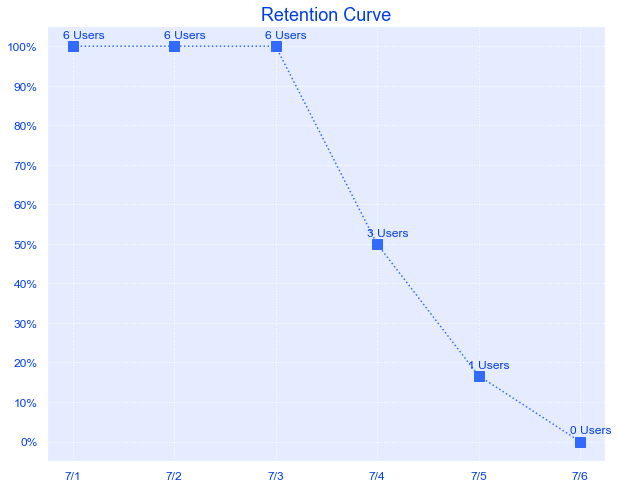

In [24]:
fig = plot_retention_curve(
    retention_df=retention_df,
    figsize=figsize,
    facecolor=facecolor,
    linecolor=linecolor,
    linestyle=linestyle,
    marker=marker,
    markersize=markersize,
    fontfamily=fontfamily,
    fontcolor=fontcolor,
    fontsize=fontsize
)

In [30]:
# fig.savefig("../images/test_retention_curve.png")

## TASK2: 시간에 따른 Activer Users 변화 &rarr; Bar Plot

## TASK3: 리텐션 라이프사이클에 따른 User Group 분포 &rarr; Nested Pie Chart